#  Principal Component Analysis

## Until now, we studied supervised learning, where models learn from labeled data to predict known outcomes.

## Now, we move to unsupervised learning, where models find hidden patterns and structures in data without using any labels.

PCA is fundamentally a dimensionality reduction algorithm, but it can also be useful as a tool for
* visualization,
* noise filtering,
* feature extraction


After a brief conceptual discussion of the PCA algorithm, we will explore a couple examples of these further applications.



In [1]:
# standard imports:

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


1. **Each matrix**
   \[
   \Sigma =
   \begin{bmatrix}
   \sigma_1^2 & \rho\,\sigma_1\sigma_2\\
   \rho\,\sigma_1\sigma_2 & \sigma_2^2
   \end{bmatrix}
   \]
   defines the **shape** and **orientation** of the probability ellipse.

2. **Case 1:** \( \sigma_1 = \sigma_2, \rho = 0 \) → circular cloud (equal spread).

3. **Case 2:** \( \sigma_1 \neq \sigma_2, \rho = 0 \) → ellipse stretched along coordinate axes.

4. **Case 3:** \( \sigma_1 = \sigma_2, \rho \neq 0 \) → same spread but **tilted**; correlation rotates the ellipse.

In [9]:
# Interactive bivariate normal demo with fixed heatmap cell labels
# pip install plotly ipywidgets

import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import interact, FloatSlider, VBox, HBox, HTML

def make_cov(s1, s2, rho):
    return np.array([[s1**2, rho*s1*s2],
                     [rho*s1*s2, s2**2]])

def ellipse_from_cov(Sigma, k=2.4477, n=200):
    vals, vecs = np.linalg.eigh(Sigma)
    axes = np.sqrt(vals) * k
    t = np.linspace(0, 2*np.pi, n)
    circle = np.vstack([np.cos(t), np.sin(t)])
    E = (vecs @ np.diag(axes)) @ circle
    return E[0], E[1]

def base_layout():
    fig = make_subplots(
        rows=1, cols=2, column_widths=[0.62, 0.38],
        subplot_titles=("Samples + 95% Ellipse", "Covariance Matrix Σ"),
        specs=[[{"type":"scatter"}, {"type":"heatmap"}]]
    )
    fig.update_layout(
        height=460, width=980, template="plotly_white",
        margin=dict(l=40, r=30, t=60, b=40),
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1.0)
    )
    fig.update_xaxes(title_text="x₁", row=1, col=1)
    fig.update_yaxes(title_text="x₂", row=1, col=1)
    return fig

def render(s1=1.0, s2=1.6, rho=0.4, n=800, seed=0):
    rho = float(np.clip(rho, -0.98, 0.98))
    Sigma = make_cov(s1, s2, rho)

    rng = np.random.default_rng(seed)
    X = rng.multivariate_normal([0.0, 0.0], Sigma, size=n)

    ex, ey = ellipse_from_cov(Sigma)

    fig = base_layout()
    fig.add_trace(go.Scatter(
        x=X[:,0], y=X[:,1], mode="markers",
        marker=dict(size=4, opacity=0.35),
        name="Samples"
    ), row=1, col=1)
    fig.add_trace(go.Scatter(
        x=ex, y=ey, mode="lines",
        line=dict(width=3, color="#e45756"),
        name="95% ellipse"
    ), row=1, col=1)

    vmax = float(np.max(np.abs(Sigma))) or 1.0

    # Heatmap with in-cell text; reverse y to align text with cells
    fig.add_trace(
        go.Heatmap(
            z=Sigma,
            x=["x₁","x₂"],
            y=["x₁","x₂"],
            colorscale="RdBu",
            zmin=-vmax, zmax=vmax, zmid=0.0,
            colorbar=dict(title="Covariance"),
            text=[[f"{Sigma[i,j]:.2f}" for j in range(2)] for i in range(2)],
            texttemplate="%{text}",
            textfont={"size":14, "color":"black"},
            hovertemplate="Cov(%{y}, %{x}) = %{z:.2f}<extra></extra>"
        ),
        row=1, col=2
    )
    # Critical for heatmap/text alignment
    fig.update_yaxes(autorange="reversed", row=1, col=2)

    lim = 3*max(s1, s2)
    fig.update_xaxes(range=[-lim, lim], row=1, col=1)
    fig.update_yaxes(range=[-lim, lim], scaleanchor="x1", scaleratio=1, row=1, col=1)

    return fig

# Sliders
s1 = FloatSlider(value=1.0, min=0.3, max=3.0, step=0.1, description='σ₁', readout_format='.1f')
s2 = FloatSlider(value=1.6, min=0.3, max=3.0, step=0.1, description='σ₂', readout_format='.1f')
rho = FloatSlider(value=0.4, min=-0.95, max=0.95, step=0.05, description='ρ', readout_format='.2f')

def update(s1, s2, rho):
    render(s1=s1, s2=s2, rho=rho).show()

_ = interact(update, s1=s1, s2=s2, rho=rho)

interactive(children=(FloatSlider(value=1.0, description='σ₁', max=3.0, min=0.3, readout_format='.1f'), FloatS…

In [ ]:
# Interactive multivariate normal demo
# Requirements: plotly, ipywidgets
# pip install plotly ipywidgets

import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import interact, FloatSlider, IntSlider, Dropdown, VBox, HBox, HTML

def equicorr(d, rho):
    C = np.full((d, d), rho)
    np.fill_diagonal(C, 1.0)
    return C

def make_cov(sigmas, rho):
    # PSD guard for equicorrelation: rho >= -1/(d-1)
    d = len(sigmas)
    rho_min = -1.0 / (d - 1) + 1e-6 if d > 1 else -0.999
    rho = float(np.clip(rho, rho_min, 0.98))
    S = np.diag(sigmas)
    C = equicorr(d, rho)
    return S @ C @ S

def ellipse_from_cov2(Sigma2, k=2.4477, n=200):
    vals, vecs = np.linalg.eigh(Sigma2)
    vals = np.clip(vals, 1e-12, None)
    axes = np.sqrt(vals) * k
    t = np.linspace(0, 2*np.pi, n)
    circle = np.vstack([np.cos(t), np.sin(t)])
    E = (vecs @ np.diag(axes)) @ circle
    return E[0], E[1]

def base_layout():
    fig = make_subplots(
        rows=1, cols=2, column_widths=[0.62, 0.38],
        subplot_titles=("Samples in selected 2D", "Covariance matrix Sigma"),
        specs=[[{"type":"scatter"}, {"type":"heatmap"}]]
    )
    fig.update_layout(
        height=520, width=1040, template="plotly_white",
        margin=dict(l=40, r=30, t=60, b=40),
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1.0)
    )
    fig.update_xaxes(title_text="x axis", row=1, col=1)
    fig.update_yaxes(title_text="y axis", row=1, col=1)
    return fig

def render(d=4, s1=1.0, s2=1.2, s3=1.5, s4=0.8, rho=0.4, proj_x=0, proj_y=1, n=1200, seed=0):
    sigmas_all = [s1, s2, s3, s4]
    sigmas = np.array(sigmas_all[:d], dtype=float)

    Sigma = make_cov(sigmas, rho)

    rng = np.random.default_rng(seed)
    X = rng.multivariate_normal(np.zeros(d), Sigma, size=n)

    # 2D projection indices
    i, j = int(proj_x), int(proj_y)
    i = np.clip(i, 0, d-1); j = np.clip(j, 0, d-1)
    if i == j:
        j = (i + 1) % d
    X2 = X[:, [i, j]]
    Sigma2 = Sigma[[i, j]][:, [i, j]]

    ex, ey = ellipse_from_cov2(Sigma2)

    fig = base_layout()

    # Left: samples and 95 percent ellipse
    fig.add_trace(go.Scatter(
        x=X2[:, 0], y=X2[:, 1], mode="markers",
        marker=dict(size=4, opacity=0.35),
        name="samples"
    ), row=1, col=1)
    fig.add_trace(go.Scatter(
        x=ex, y=ey, mode="lines",
        line=dict(width=3, color="#e45756"),
        name="95 percent ellipse"
    ), row=1, col=1)

    # Axis equal
    lim = 3.5 * max(sigmas[i], sigmas[j])
    fig.update_xaxes(range=[-lim, lim], row=1, col=1)
    fig.update_yaxes(range=[-lim, lim], scaleanchor="x1", scaleratio=1, row=1, col=1)

    # Right: covariance heatmap with values
    vmax = float(np.max(np.abs(Sigma)))
    vmax = vmax if vmax > 0 else 1.0
    labels = [f"x{k+1}" for k in range(d)]

    fig.add_trace(
        go.Heatmap(
            z=Sigma, x=labels, y=labels,
            colorscale="RdBu", zmin=-vmax, zmax=vmax, zmid=0.0,
            colorbar=dict(title="Covariance"),
            text=[[f"{Sigma[r,c]:.2f}" for c in range(d)] for r in range(d)],
            texttemplate="%{text}",
            textfont={"size":14, "color":"black"},
            hovertemplate="Cov(%{y}, %{x}) = %{z:.3f}<extra></extra>"
        ),
        row=1, col=2
    )
    fig.update_yaxes(autorange="reversed", row=1, col=2)

    # Titles
    fig.update_xaxes(title_text=f"x{ i+1 }", row=1, col=1)
    fig.update_yaxes(title_text=f"x{ j+1 }", row=1, col=1)

    return fig

# Widgets
dim = IntSlider(value=4, min=2, max=4, step=1, description="dims")
s1 = FloatSlider(value=1.0, min=0.3, max=3.0, step=0.1, description="sigma1")
s2 = FloatSlider(value=1.2, min=0.3, max=3.0, step=0.1, description="sigma2")
s3 = FloatSlider(value=1.5, min=0.3, max=3.0, step=0.1, description="sigma3")
s4 = FloatSlider(value=0.8, min=0.3, max=3.0, step=0.1, description="sigma4")
rho = FloatSlider(value=0.4, min=-0.95, max=0.95, step=0.05, description="rho")

proj_x = Dropdown(options=[("x1",0),("x2",1),("x3",2),("x4",3)], value=0, description="x axis")
proj_y = Dropdown(options=[("y1",0),("y2",1),("y3",2),("y4",3)], value=1, description="y axis")

def _update_options(d):
    opts = [(f"x{k+1}", k) for k in range(d)]
    proj_x.options = opts
    proj_y.options = opts
_update_options(dim.value)

def update(d, s1, s2, s3, s4, rho, proj_x, proj_y):
    _update_options(d)
    fig = render(d=d, s1=s1, s2=s2, s3=s3, s4=s4, rho=rho, proj_x=proj_x, proj_y=proj_y)
    fig.show()

ui = VBox([
    HTML("<b>Interactive multivariate normal</b>  Sigma = S Corr S with equicorrelation"),
    HBox([dim, rho]),
    HBox([s1, s2, s3, s4]),
    HBox([proj_x, proj_y])
])

_ = interact(update, d=dim, s1=s1, s2=s2, s3=s3, s4=s4, rho=rho, proj_x=proj_x, proj_y=proj_y)
ui

interactive(children=(IntSlider(value=4, description='dims', max=4, min=2), FloatSlider(value=1.0, description…

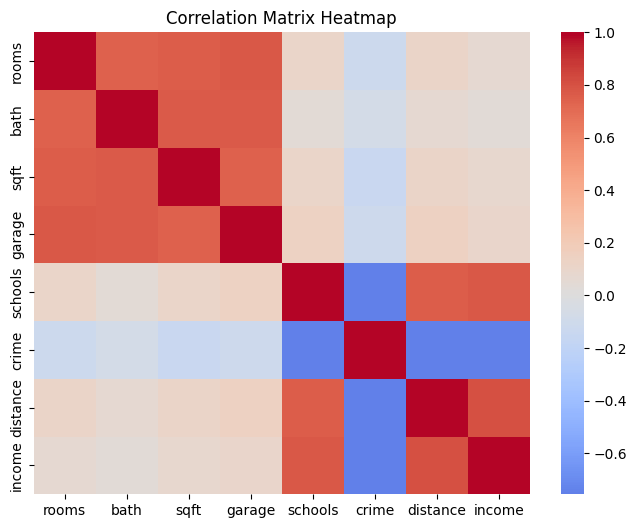

Covariance Matrix:
                rooms        bath           sqft      garage      schools  \
rooms       1.170565    0.578442     226.712141    0.402969     0.165186   
bath        0.578442    0.520655     153.051205    0.265776     0.042117   
sqft      226.712141  153.051205   76365.107914   98.431732    41.912809   
garage      0.402969    0.265776      98.431732    0.229164     0.096007   
schools     0.165186    0.042117      41.912809    0.096007     2.052282   
crime      -1.244739   -0.508013    -380.886596   -0.521502   -10.258421   
distance    0.234267    0.091537      57.394686    0.133176     2.052900   
income    590.375758  190.326319  177182.411264  363.295200  8387.138229   

                 crime      distance        income  
rooms        -1.244739      0.234267  5.903758e+02  
bath         -0.508013      0.091537  1.903263e+02  
sqft       -380.886596     57.394686  1.771824e+05  
garage       -0.521502      0.133176  3.632952e+02  
schools     -10.258421      2.

In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(42)
n = 200

mean1 = np.zeros(4)
cov1 = np.full((4,4), 0.8)  
np.fill_diagonal(cov1, 1)
group1 = np.random.multivariate_normal(mean1, cov1, n)

mean2 = np.zeros(4)
cov2 = np.full((4,4), 0.8)
np.fill_diagonal(cov2, 1)
group2 = np.random.multivariate_normal(mean2, cov2, n)

data = np.hstack((group1, group2))
df = pd.DataFrame(data, columns=["rooms", "bath", "sqft", "garage", 
                                 "schools", "crime", "distance", "income"])

df["rooms"] = 3 + df["rooms"] * 1.2
df["bath"] = 2 + df["bath"] * 0.8
df["sqft"] = 1500 + df["sqft"] * 300
df["garage"] = 1 + df["garage"] * 0.5
df["schools"] = 5 + df["schools"] * 1.5
df["crime"] = 50 - df["crime"] * 10
df["distance"] = 10 + df["distance"] * 2
df["income"] = 60000 + df["income"] * 8000

corr = df.corr()
cov = df.cov()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title("Correlation Matrix Heatmap")
plt.show()

print("Covariance Matrix:\n", cov)

Mean vector:
 [3.080000e+00 2.050000e+00 1.515330e+03 1.030000e+00 4.840000e+00
 5.157000e+01 9.710000e+00 5.931653e+04]

Covariance matrix shape: (8, 8)


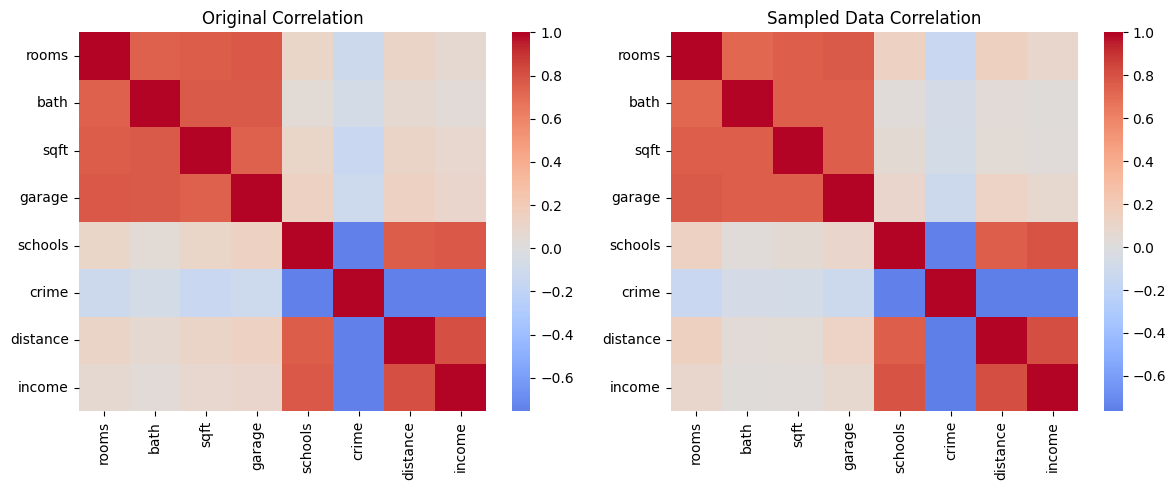

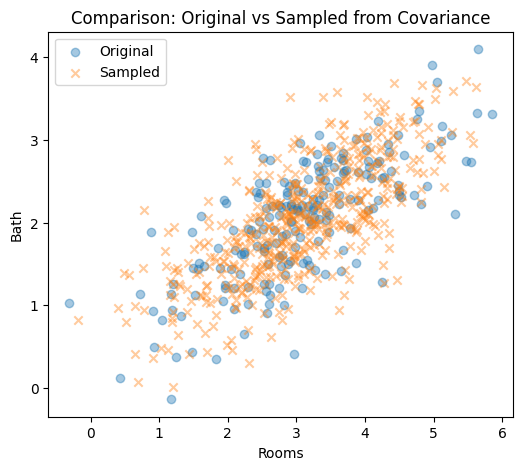

In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Your existing dataset
np.random.seed(42)
n = 200

mean1 = np.zeros(4)
cov1 = np.full((4,4), 0.8)
np.fill_diagonal(cov1, 1)
group1 = np.random.multivariate_normal(mean1, cov1, n)

mean2 = np.zeros(4)
cov2 = np.full((4,4), 0.8)
np.fill_diagonal(cov2, 1)
group2 = np.random.multivariate_normal(mean2, cov2, n)

data = np.hstack((group1, group2))
df = pd.DataFrame(data, columns=["rooms", "bath", "sqft", "garage", 
                                 "schools", "crime", "distance", "income"])

# Step 2: Apply scaling
df["rooms"] = 3 + df["rooms"] * 1.2
df["bath"] = 2 + df["bath"] * 0.8
df["sqft"] = 1500 + df["sqft"] * 300
df["garage"] = 1 + df["garage"] * 0.5
df["schools"] = 5 + df["schools"] * 1.5
df["crime"] = 50 - df["crime"] * 10
df["distance"] = 10 + df["distance"] * 2
df["income"] = 60000 + df["income"] * 8000

# Step 3: Compute mean and covariance matrix
mean_vec = df.mean().values
cov_mat = df.cov().values

print("Mean vector:\n", np.round(mean_vec, 2))
print("\nCovariance matrix shape:", cov_mat.shape)

# Step 4: Sample new points from same covariance structure
np.random.seed(0)
new_samples = np.random.multivariate_normal(mean_vec, cov_mat, size=500)

# Step 5: Convert to DataFrame
df_new = pd.DataFrame(new_samples, columns=df.columns)

# Step 6: Visualize correlation similarity between original and sampled
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(df.corr(), cmap="coolwarm", center=0, ax=axes[0])
axes[0].set_title("Original Correlation")

sns.heatmap(df_new.corr(), cmap="coolwarm", center=0, ax=axes[1])
axes[1].set_title("Sampled Data Correlation")

plt.tight_layout()
plt.show()

# Step 7: Scatter comparison (check shape similarity)
plt.figure(figsize=(6, 5))
plt.scatter(df["rooms"], df["bath"], alpha=0.4, label="Original")
plt.scatter(df_new["rooms"], df_new["bath"], alpha=0.4, label="Sampled", marker="x")
plt.xlabel("Rooms")
plt.ylabel("Bath")
plt.title("Comparison: Original vs Sampled from Covariance")
plt.legend()
plt.show()

In [55]:
data.shape
data=df_new

Sampled dataset shape: 500 samples × 8 features
Eigenvalues:
 [5.53943018e+07 7.29818700e+04 3.48300000e+01 1.06000000e+00
 5.80000000e-01 5.00000000e-01 1.70000000e-01 6.00000000e-02]

First 3 Eigenvectors (Principal Directions):
 [[-0.    -0.003 -0.009]
 [-0.    -0.002 -0.002]
 [-0.001 -1.     0.002]
 [-0.    -0.001 -0.004]
 [-0.    -0.    -0.055]
 [ 0.001  0.002  0.996]
 [-0.    -0.    -0.063]
 [-1.     0.001  0.001]]


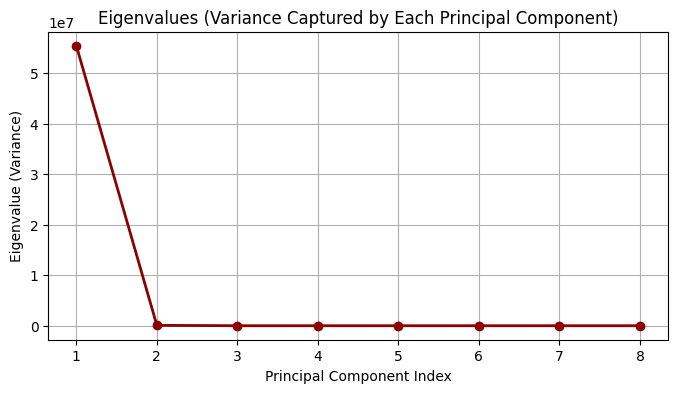

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

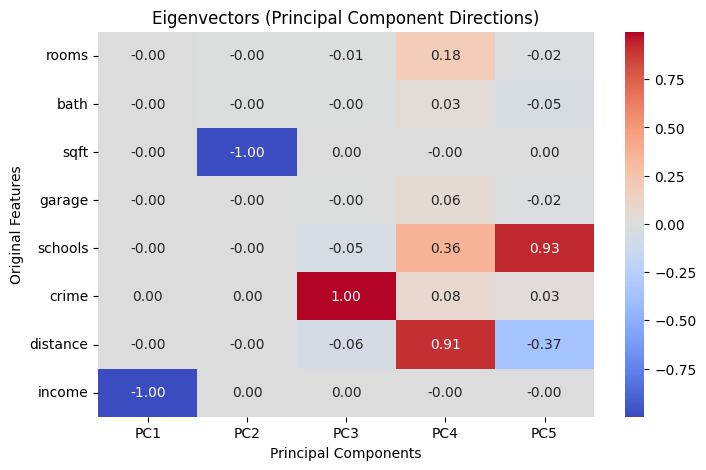

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Take the sampled dataset
X = df_new.values
n, d = X.shape
print(f"Sampled dataset shape: {n} samples × {d} features")

# Step 2: Center the data
X_centered = X - X.mean(axis=0)

# Step 3: Compute covariance matrix
Sigma = (X_centered.T @ X_centered) / (n - 1)

# Step 4: Eigen-decomposition
eigvals, eigvecs = np.linalg.eigh(Sigma)
idx = np.argsort(eigvals)[::-1]
eigvals, eigvecs = eigvals[idx], eigvecs[:, idx]

print("Eigenvalues:\n", np.round(eigvals, 2))
print("\nFirst 3 Eigenvectors (Principal Directions):\n", np.round(eigvecs[:, :3], 3))

# Step 5: Plot eigenvalues (variance explained)
plt.figure(figsize=(8, 4))
plt.plot(range(1, d + 1), eigvals, 'o-', color='darkred', linewidth=2)
plt.title("Eigenvalues (Variance Captured by Each Principal Component)")
plt.xlabel("Principal Component Index")
plt.ylabel("Eigenvalue (Variance)")
plt.grid(True)
plt.show()

# Step 6: Plot eigenvectors as heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(eigvecs[:, :5],
            annot=True, fmt=".2f", cmap="coolwarm",
            xticklabels=[f"PC{i+1}" for i in range(5)],
            yticklabels=df_new.columns)
plt.title("Eigenvectors (Principal Component Directions)")
plt.xlabel("Principal Components")
plt.ylabel("Original Features")
plt.tight_layout

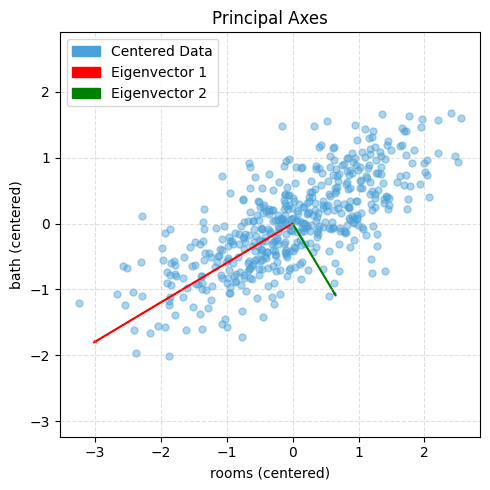

In [61]:
# Plot centered data with principal axes (like the example figure)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ---- choose any two features; here: rooms vs bath from df_new ----
X2 = df_new[["rooms", "bath"]].values

# Center
M = X2 - X2.mean(axis=0)

# Covariance and eigendecomposition
Sigma = (M.T @ M) / (len(M) - 1)
eigvals, eigvecs = np.linalg.eigh(Sigma)
idx = np.argsort(eigvals)[::-1]
eigvals, eigvecs = eigvals[idx], eigvecs[:, idx]

# Scale arrows by sqrt(variance) for visibility
scale = 3.0
v1 = eigvecs[:, 0] * np.sqrt(eigvals[0]) * scale
v2 = eigvecs[:, 1] * np.sqrt(eigvals[1]) * scale

# Plot
plt.figure(figsize=(5, 5))
plt.scatter(M[:, 0], M[:, 1], s=25, alpha=0.45, color="#4aa0d8", label="Centered Data")

# Eigenvector 1 (red) and 2 (green)
plt.arrow(0, 0, v1[0], v1[1], color="red", width=0.01, length_includes_head=True)
plt.arrow(0, 0, v2[0], v2[1], color="green", width=0.01, length_includes_head=True)

# Legend blocks to match styles
legend_elements = [
    Patch(facecolor="#4aa0d8", edgecolor="#4aa0d8", label="Centered Data"),
    Patch(facecolor="red", edgecolor="red", label="Eigenvector 1"),
    Patch(facecolor="green", edgecolor="green", label="Eigenvector 2"),
]
plt.legend(handles=legend_elements, loc="upper left", frameon=True)

plt.title("Principal Axes")
plt.xlabel("rooms (centered)")
plt.ylabel("bath (centered)")
plt.axis('equal')
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [24]:
# Choose which centered matrix to use:
M = Xc              # variance-based PCA (sensitive to units)
# M = Z            # correlation-based PCA (unitless)

# Covariance (d×d)
Sigma = (M.T @ M) / (n - 1)         # identical to np.cov(M, rowvar=False)

# Eigen-decomposition
eigvals, eigvecs = np.linalg.eigh(Sigma)   # guaranteed symmetric → eigh

# Sort by descending variance
idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]                      # λ₁ ≥ λ₂ ≥ …
eigvecs = eigvecs[:, idx]                   # columns = principal axes

# Explained variance
explained_var = eigvals
explained_var_ratio = eigvals / eigvals.sum()

# Scores (project data to PCs): T = M * V
T = M @ eigvecs                             # shape (n, d)

# Dimensionality reduction to k PCs
k = 2
Vk = eigvecs[:, :k]                         # (d, k)
Tk = M @ Vk                                 # (n, k)

# Optional reconstruction from k PCs (to see information loss)
M_hat = Tk @ Vk.T                           # (n, d)
recon_rmse = np.sqrt(np.mean((M - M_hat)**2))
print("Explained variance ratio:", explained_var_ratio)
print("RMSE (k PCs reconstruction):", recon_rmse)

Explained variance ratio: [0.43959614 0.41253489 0.02638563 0.02521931 0.02480742 0.02446876
 0.0238426  0.02314524]
RMSE (k PCs reconstruction): 0.3864285158563806


## Introducing Principal Component Analysis

Principal component analysis is a fast and flexible unsupervised method for dimensionality reduction in data, which we saw briefly in [Introducing Scikit-Learn](05.02-Introducing-Scikit-Learn.ipynb).
Its behavior is easiest to visualize by looking at a two-dimensional dataset.
Consider these 200 points (see the following figure):

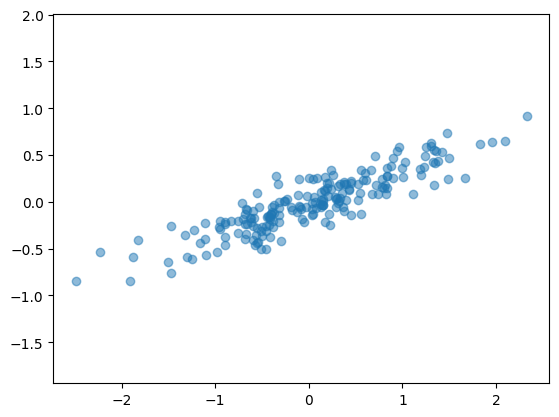

In [56]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T # shape: (200, 2)
plt.scatter(X[:, 0], X[:, 1], alpha=0.5, label="Original Data")
plt.axis('equal');

* The x and y variables clearly have a near-linear relationship.
* Unlike regression, where we predict y from x, here we aim to understand the relationship between them.
* PCA finds the main directions (principal axes) that best describe how the data varies, helping us represent the dataset more efficiently.

Mean: [ 0.03351168 -0.00408072]


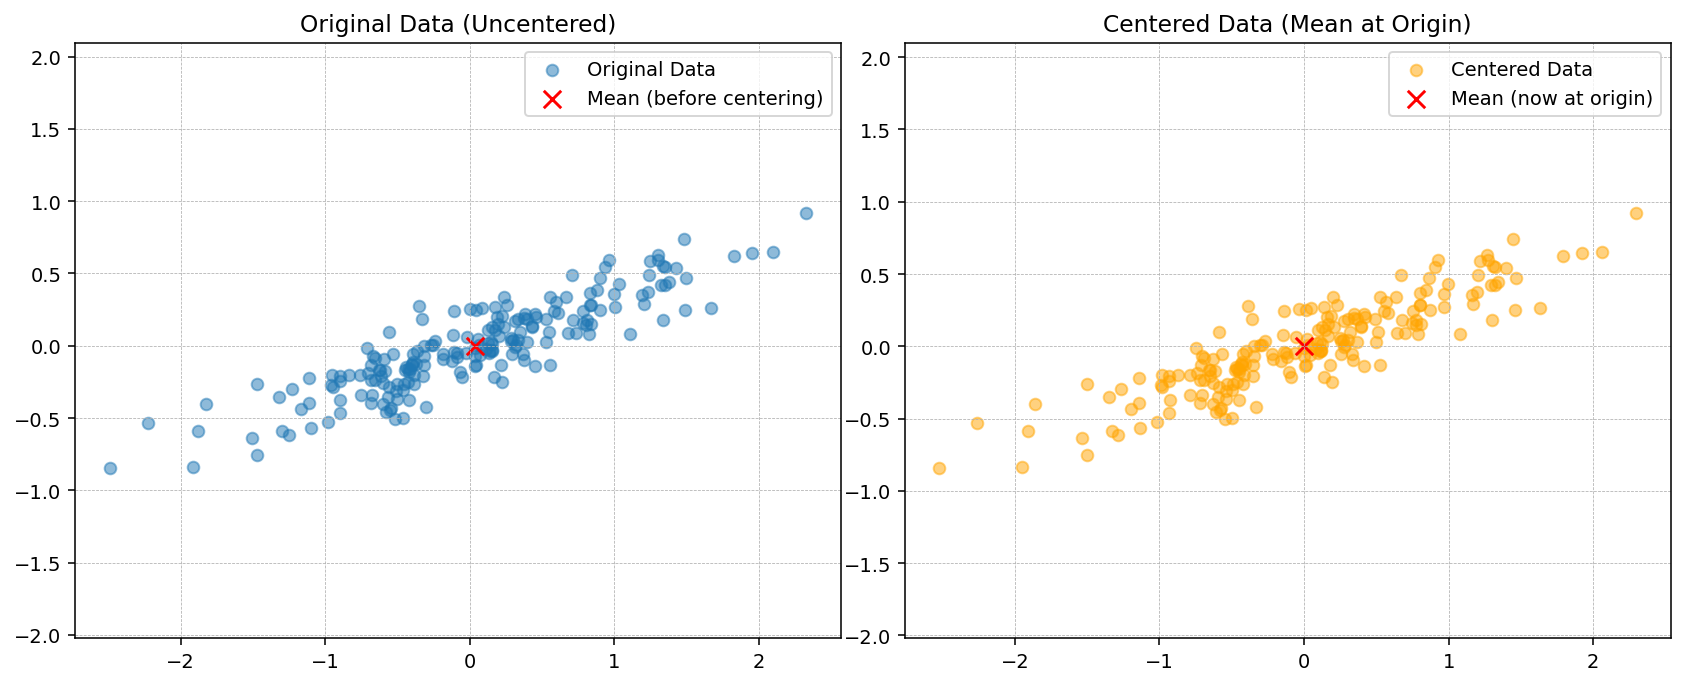

In [57]:
# Step 1: Mean of each feature
mu = X.mean(axis=0)
print("Mean:", mu)

# Step 2: center data
Xc = X - mu
# print("center data",Xc)
plt.figure(figsize=(12, 5), dpi=140)

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], alpha=0.5, label="Original Data")
plt.scatter(mu[0], mu[1], color="red", s=80, marker="x", label="Mean (before centering)")
plt.title("Original Data (Uncentered)")
plt.axis("equal")
plt.grid(True, linestyle="--", linewidth=0.4)
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(Xc[:, 0], Xc[:, 1], alpha=0.5, color="orange", label="Centered Data")
plt.scatter(0, 0, color="red", s=80, marker="x", label="Mean (now at origin)")
plt.title("Centered Data (Mean at Origin)")
plt.axis("equal")
plt.grid(True, linestyle="--", linewidth=0.4)
plt.legend()

plt.tight_layout()
plt.show()


### **Geometric Intuition**

Centering shifts the cloud of data points so that it’s **centered at the origin**.

- **PCA** then finds directions **through the origin** that best describe data spread.  
- Without centering, the **axes might not pass through the true center of variation**, leading to incorrect principal directions.

Covariance matrix:
 [[0.68217761 0.23093475]
 [0.23093475 0.09883179]]


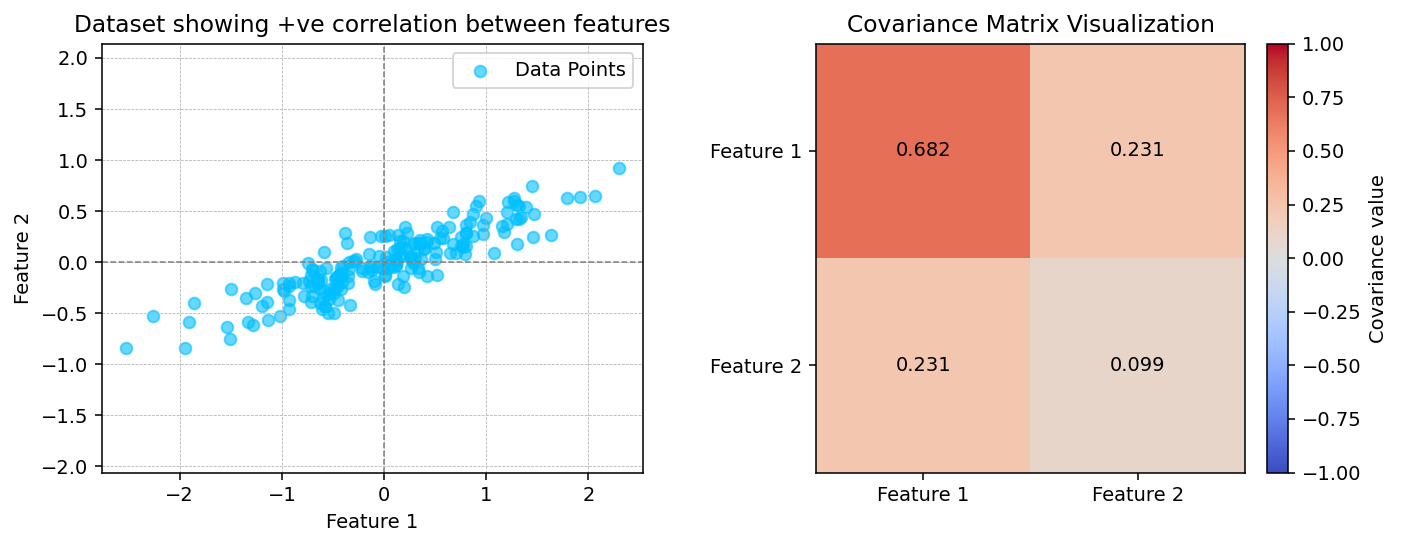

In [58]:
# Step 3: Compute covariance matrix

Sigma = np.cov(Xc.T)
print("Covariance matrix:\n", Sigma)

fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=140)
ax[0].scatter(Xc[:, 0], Xc[:, 1], alpha=0.6, color="deepskyblue", label="Data Points")
ax[0].axhline(0, color="gray", linestyle="--", linewidth=0.8)
ax[0].axvline(0, color="gray", linestyle="--", linewidth=0.8)
ax[0].set_title("Dataset showing +ve correlation between features")
ax[0].set_xlabel("Feature 1")
ax[0].set_ylabel("Feature 2")
ax[0].legend()
ax[0].grid(True, linestyle="--", linewidth=0.4)
ax[0].axis("equal")

im = ax[1].imshow(Sigma, cmap="coolwarm", interpolation="nearest", vmin=-1, vmax=1)
plt.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04, label="Covariance value")
ax[1].set_xticks([0, 1])
ax[1].set_yticks([0, 1])
ax[1].set_xticklabels(["Feature 1", "Feature 2"])
ax[1].set_yticklabels(["Feature 1", "Feature 2"])
ax[1].set_title("Covariance Matrix Visualization")

for i in range(2):
    for j in range(2):
        ax[1].text(j, i, f"{Sigma[i, j]:.3f}",
                   ha="center", va="center", color="black", fontsize=10)

# plt.suptitle("Covariance Visualization: Dataset with Positive Correlation", fontsize=12)
plt.tight_layout()


In [59]:
# # Step 3: Induce negative correlation (invert one feature)
# Xc[:, 1] *= -1  # flip y-axis to make correlation negative
# Sigma = np.cov(Xc.T)
# print("Covariance matrix:\n", Sigma)
# fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=140)
# ax[0].scatter(Xc[:, 0], Xc[:, 1], alpha=0.6, color="crimson", label="Data Points")
# ax[0].axhline(0, color="gray", linestyle="--", linewidth=0.8)
# ax[0].axvline(0, color="gray", linestyle="--", linewidth=0.8)
# ax[0].set_title("Dataset showing -ve correlation between features")
# ax[0].set_xlabel("Feature 1 (X₁)")
# ax[0].set_ylabel("Feature 2 (X₂)")
# ax[0].legend()
# ax[0].grid(True, linestyle="--", linewidth=0.4)
# ax[0].axis("equal")
# im = ax[1].imshow(Sigma, cmap="coolwarm", interpolation="nearest", vmin=-1, vmax=1)
# plt.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04, label="Covariance value")
# ax[1].set_xticks([0, 1])
# ax[1].set_yticks([0, 1])
# ax[1].set_xticklabels(["Feature 1", "Feature 2"])
# ax[1].set_yticklabels(["Feature 1", "Feature 2"])
# ax[1].set_title("Covariance Matrix Visualization")
# for i in range(2):
#     for j in range(2):
#         ax[1].text(j, i, f"{Sigma[i, j]:.3f}",
#                    ha="center", va="center", color="black", fontsize=10)
# plt.tight_layout()

**Mathematically:**  Σv = λv  
- **v:** Eigenvector → direction of maximum variance  
- **λ:** Eigenvalue → amount of variance along that direction  
- **Eigenvectors =** new axes (directions), **Eigenvalues =** importance (variance) of each axis  

Eigenvalues: [0.7625315 0.0184779]
Eigenvectors (columns):
 [[ 0.94446029 -0.32862557]
 [ 0.32862557  0.94446029]]


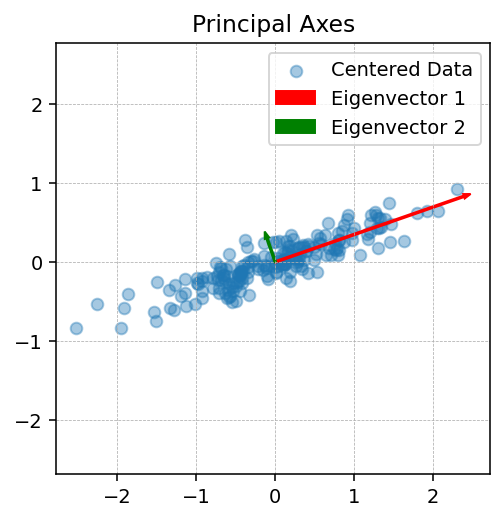

In [ ]:
# Step 4: Eigen-decomposition
eigvals, eigvecs = np.linalg.eig(Sigma)  
print("Eigenvalues:", eigvals)
print("Eigenvectors (columns):\n", eigvecs)

idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]
plt.figure(figsize=(4, 4), dpi=140)
plt.scatter(Xc[:, 0], Xc[:, 1], alpha=0.4, label="Centered Data")
origin = np.array([0, 0])
for i in range(2):
    vec = eigvecs[:, i] * np.sqrt(eigvals[i]) * 3
    plt.arrow(origin[0], origin[1], vec[0], vec[1],
              width=0.02, color="red" if i == 0 else "green",
              length_includes_head=True,
              label=f"Eigenvector {i+1}")

plt.axis("equal")
plt.title("Principal Axes")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.4)
plt.show()

# Using Scikit Learn

In [66]:
from sklearn.decomposition import PCA
# n_components=2 means the algorithm will find two orthogonal axes that capture as much variance as possible.
pca = PCA(n_components=2) 
pca.fit(X)


PCA(n_components=2)

The fit learns some quantities from the data, most importantly the components and explained variance:

In [67]:
print(pca.components_)

[[ 0.94446029  0.32862557]
 [-0.32862557  0.94446029]]


In [68]:
print(pca.explained_variance_)

[0.7625315 0.0184779]


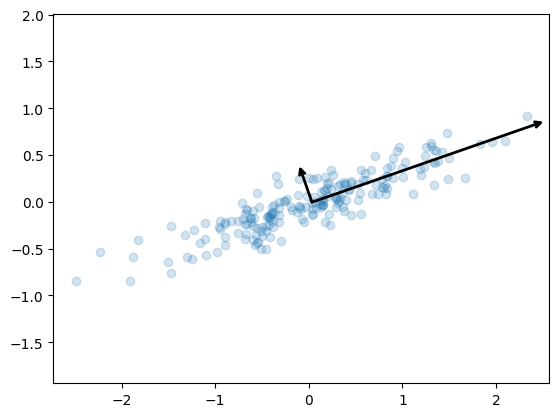

In [7]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->', linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

* This transformation from data axes to principal axes is an *affine transformation*, which means it is composed of a translation, rotation, and uniform scaling.

# Covariance matrix visualizations (+ve, −ve correlations)

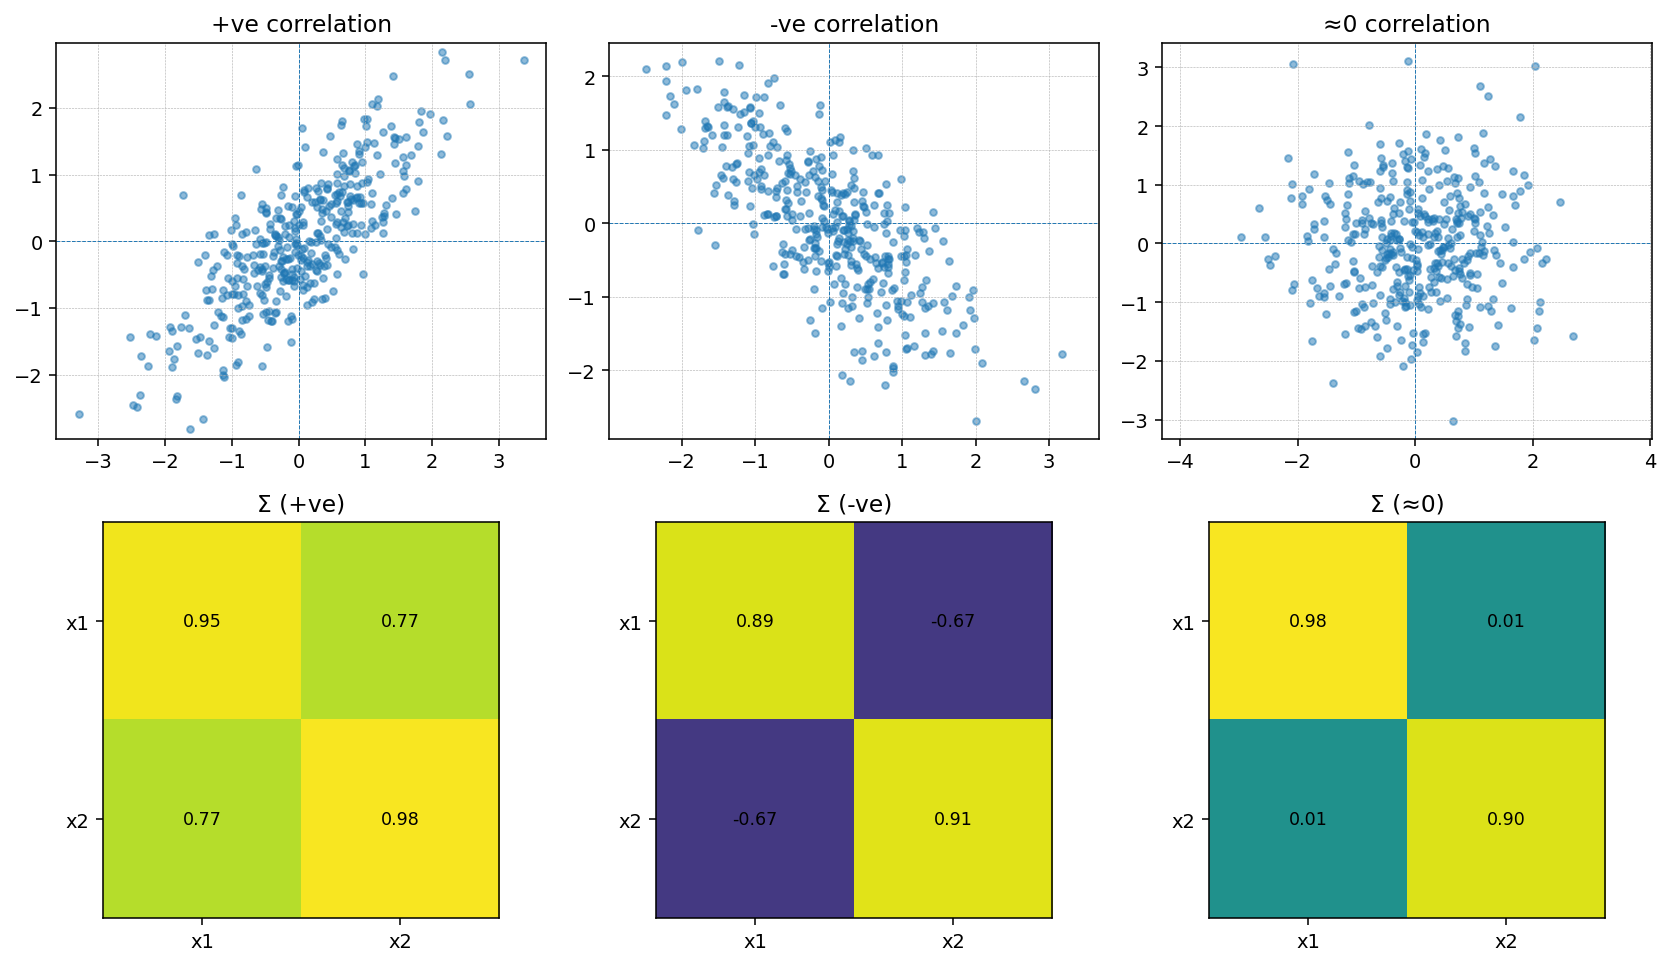

In [71]:
np.random.seed(42)
n = 400
mean = [0, 0]
cov_pos = [[1, 0.8], [0.8, 1]]
cov_neg = [[1, -0.8], [-0.8, 1]]
cov_zero = [[1, 0.0], [0.0, 1]]

X_pos = np.random.multivariate_normal(mean, cov_pos, n)
X_neg = np.random.multivariate_normal(mean, cov_neg, n)
X_zero = np.random.multivariate_normal(mean, cov_zero, n)

datasets = [X_pos, X_neg, X_zero]
titles_scatter = ["+ve correlation", "-ve correlation", "≈0 correlation"]
titles_cov = ["Σ (+ve)", "Σ (-ve)", "Σ (≈0)"]

fig, ax = plt.subplots(2, 3, figsize=(12, 7), dpi=140)

for j, X in enumerate(datasets):
    mu = X.mean(axis=0)
    Xc = X - mu
    Sigma = np.cov(Xc.T)

    # scatter
    ax[0, j].scatter(Xc[:, 0], Xc[:, 1], alpha=0.5, s=12)
    ax[0, j].set_title(titles_scatter[j])
    ax[0, j].axhline(0, linestyle="--", linewidth=0.5)
    ax[0, j].axvline(0, linestyle="--", linewidth=0.5)
    ax[0, j].axis("equal")
    ax[0, j].grid(True, linestyle="--", linewidth=0.3)

    # covariance heatmap
    im = ax[1, j].imshow(Sigma, vmin=-1, vmax=1, interpolation="nearest")
    ax[1, j].set_xticks([0, 1]); ax[1, j].set_yticks([0, 1])
    ax[1, j].set_xticklabels(["x1", "x2"]); ax[1, j].set_yticklabels(["x1", "x2"])
    ax[1, j].set_title(titles_cov[j])
    for r in range(2):
        for c in range(2):
            ax[1, j].text(c, r, f"{Sigma[r, c]:.2f}", ha="center", va="center", fontsize=9)

# fig.colorbar(im, ax=ax[1, :], fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()

### Visualizing Covariance Structure

PCA is built on the covariance matrix, so it helps to see how covariance encodes the relationships between features.
Below we construct two toy Gaussian datasets by *sampling from a specified covariance matrix*: one with a strong positive correlation and one with a strong negative correlation.


Sampling with `np.random.multivariate_normal` lets us translate a desired covariance structure directly into synthetic data.
With positive covariance the samples align with the $+45^{\circ}$ diagonal, while a negative covariance flips the cloud onto the $-45^{\circ}$ diagonal.
PCA uses these same covariance patterns to decide which axes (principal components) capture the dominant variability.


### PCA as Dimensionality Reduction

Using PCA for dimensionality reduction involves zeroing out one or more of the smallest principal components, resulting in a lower-dimensional projection of the data that preserves the maximal data variance.

Here is an example of using PCA as a dimensionality reduction transform:

In [10]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


The transformed data has been reduced to a single dimension.
To understand the effect of this dimensionality reduction, we can perform the inverse transform of this reduced data and plot it along with the original data (see the following figure):

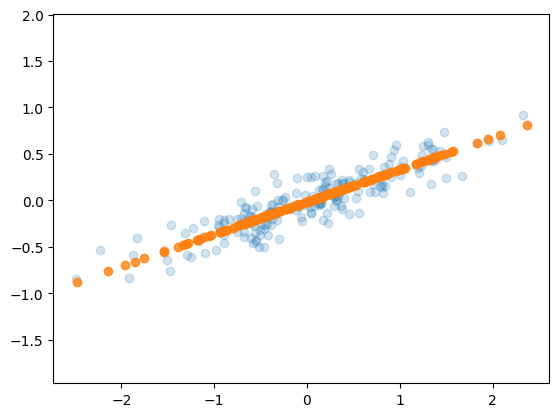

In [11]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

The light points are the original data, while the dark points are the projected version.
This makes clear what a PCA dimensionality reduction means: the information along the least important principal axis or axes is removed, leaving only the component(s) of the data with the highest variance.
The fraction of variance that is cut out (proportional to the spread of points about the line formed in the preceding figure) is roughly a measure of how much "information" is discarded in this reduction of dimensionality.

This reduced-dimension dataset is in some senses "good enough" to encode the most important relationships between the points: despite reducing the number of data features by 50%, the overall relationships between the data points are mostly preserved.

### PCA for Visualization: Handwritten Digits

The usefulness of dimensionality reduction may not be entirely apparent in only two dimensions, but it becomes clear when looking at high-dimensional data.
To see this, let's take a quick look at the application of PCA to the digits dataset we worked with in [In-Depth: Decision Trees and Random Forests](05.08-Random-Forests.ipynb).

We'll start by loading the data:

In [12]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

Recall that the digits dataset consists of 8 × 8–pixel images, meaning that they are 64-dimensional.
To gain some intuition into the relationships between these points, we can use PCA to project them into a more manageable number of dimensions, say two:

In [13]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


We can now plot the first two principal components of each point to learn about the data, as seen in the following figure:

/tmp/ipykernel_3584972/2943749715.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap('rainbow', 10))


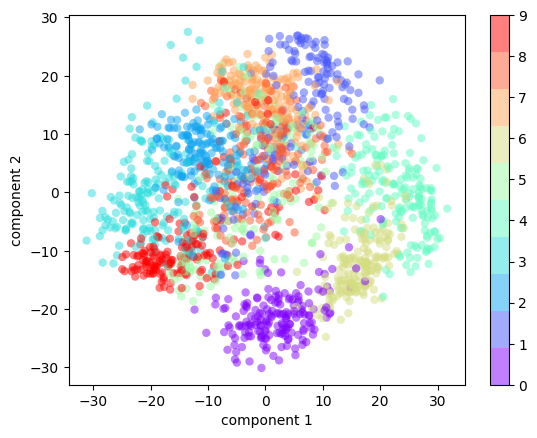

In [14]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('rainbow', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

Recall what these components mean: the full data is a 64-dimensional point cloud, and these points are the projection of each data point along the directions with the largest variance.
Essentially, we have found the optimal stretch and rotation in 64-dimensional space that allows us to see the layout of the data in two dimensions, and we have done this in an unsupervised manner—that is, without reference to the labels.

### What Do the Components Mean?

We can go a bit further here, and begin to ask what the reduced dimensions *mean*.
This meaning can be understood in terms of combinations of basis vectors.
For example, each image in the training set is defined by a collection of 64 pixel values, which we will call the vector $x$:

$$
x = [x_1, x_2, x_3 \cdots x_{64}]
$$

One way we can think about this is in terms of a pixel basis.
That is, to construct the image, we multiply each element of the vector by the pixel it describes, and then add the results together to build the image:

$$
{\rm image}(x) = x_1 \cdot{\rm (pixel~1)} + x_2 \cdot{\rm (pixel~2)} + x_3 \cdot{\rm (pixel~3)} \cdots x_{64} \cdot{\rm (pixel~64)}
$$

One way we might imagine reducing the dimensionality of this data is to zero out all but a few of these basis vectors.
For example, if we use only the first eight pixels, we get an eight-dimensional projection of the data (the following figure). However, it is not very reflective of the whole image: we've thrown out nearly 90% of the pixels!

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/images/05.09-digits-pixel-components.png?raw=1)
[figure source in Appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Digits-Pixel-Components)

The upper row of panels shows the individual pixels, and the lower row shows the cumulative contribution of these pixels to the construction of the image.
Using only eight of the pixel-basis components, we can only construct a small portion of the 64-pixel image.
Were we to continue this sequence and use all 64 pixels, we would recover the original image.

But the pixel-wise representation is not the only choice of basis. We can also use other basis functions, which each contain some predefined contribution from each pixel, and write something like:

$$
image(x) = {\rm mean} + x_1 \cdot{\rm (basis~1)} + x_2 \cdot{\rm (basis~2)} + x_3 \cdot{\rm (basis~3)} \cdots
$$

PCA can be thought of as a process of choosing optimal basis functions, such that adding together just the first few of them is enough to suitably reconstruct the bulk of the elements in the dataset.
The principal components, which act as the low-dimensional representation of our data, are simply the coefficients that multiply each of the elements in this series.
the following figure shows a similar depiction of reconstructing the same digit using the mean plus the first eight PCA basis functions.

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/images/05.09-digits-pca-components.png?raw=1)
[figure source in Appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Digits-PCA-Components)

Unlike the pixel basis, the PCA basis allows us to recover the salient features of the input image with just a mean, plus eight components!
The amount of each pixel in each component is the corollary of the orientation of the vector in our two-dimensional example.
This is the sense in which PCA provides a low-dimensional representation of the data: it discovers a set of basis functions that are more efficient than the native pixel basis of the input data.

### Choosing the Number of Components

A vital part of using PCA in practice is the ability to estimate how many components are needed to describe the data.
This can be determined by looking at the cumulative *explained variance ratio* as a function of the number of components (see the following figure):

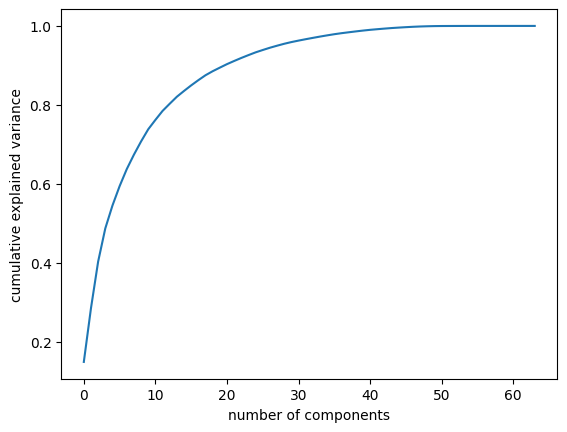

In [15]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

This curve quantifies how much of the total, 64-dimensional variance is contained within the first $N$ components.
For example, we see that with the digits data the first 10 components contain approximately 75% of the variance, while you need around 50 components to describe close to 100% of the variance.

This tells us that our 2-dimensional projection loses a lot of information (as measured by the explained variance) and that we'd need about 20 components to retain 90% of the variance.  Looking at this plot for a high-dimensional dataset can help you understand the level of redundancy present in its features.

## PCA as Noise Filtering

PCA can also be used as a filtering approach for noisy data.
The idea is this: any components with variance much larger than the effect of the noise should be relatively unaffected by the noise.
So, if you reconstruct the data using just the largest subset of principal components, you should be preferentially keeping the signal and throwing out the noise.

Let's see how this looks with the digits data.
First we will plot several of the input noise-free input samples (the following figure):

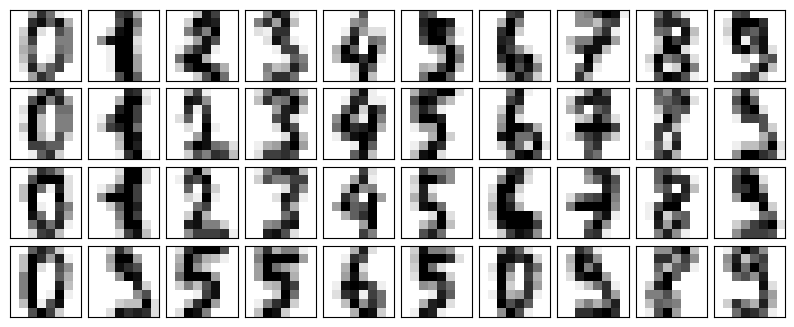

In [16]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)

Now let's add some random noise to create a noisy dataset, and replot it (the following figure):

In [17]:
rng = np.random.default_rng(42)
rng.normal(10, 2)

10.609434159508863

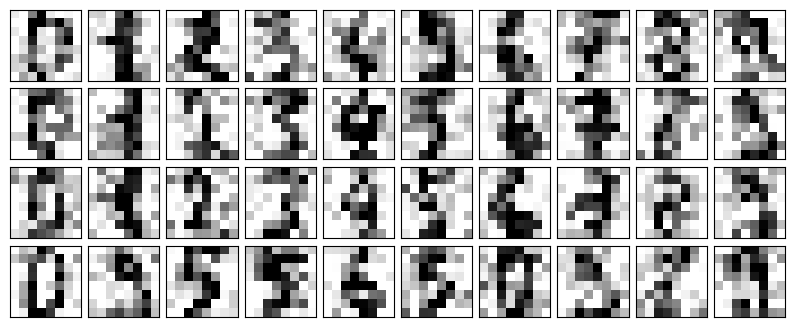

In [18]:
rng = np.random.default_rng(42)
noisy = rng.normal(digits.data, 4)
plot_digits(noisy)

The visualization makes the presence of this random noise clear.
Let's train a PCA model on the noisy data, requesting that the projection preserve 50% of the variance:

In [19]:
pca = PCA(0.50).fit(noisy)
pca.n_components_

12

Here 50% of the variance amounts to 12 principal components, out of the 64 original features.
Now we compute these components, and then use the inverse of the transform to reconstruct the filtered digits; the following figure shows the result:

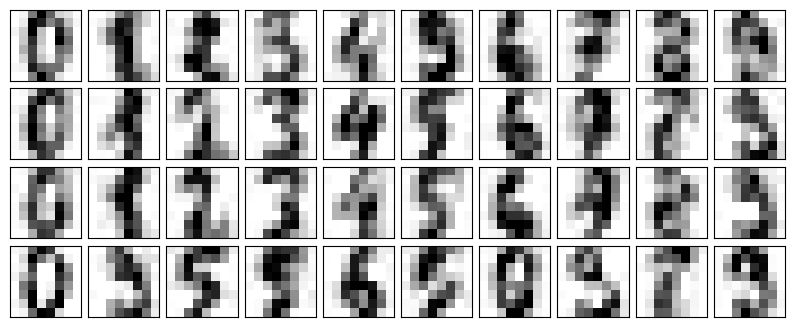

In [20]:
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

This signal preserving/noise filtering property makes PCA a very useful feature selection routine—for example, rather than training a classifier on very high-dimensional data, you might instead train the classifier on the lower-dimensional principal component representation, which will automatically serve to filter out random noise in the inputs.

## PCA and Multicollinearity: Housing Example

Many real-world tabular datasets contain strongly correlated (multicollinear) features, which can make linear models unstable.
Here we revisit the California housing dataset to see how PCA re-expresses these features into uncorrelated components.


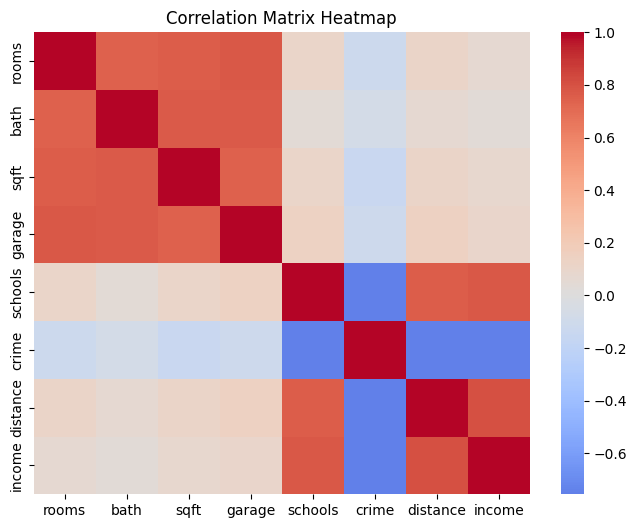

Covariance Matrix:
                rooms        bath           sqft      garage      schools  \
rooms       1.170565    0.578442     226.712141    0.402969     0.165186   
bath        0.578442    0.520655     153.051205    0.265776     0.042117   
sqft      226.712141  153.051205   76365.107914   98.431732    41.912809   
garage      0.402969    0.265776      98.431732    0.229164     0.096007   
schools     0.165186    0.042117      41.912809    0.096007     2.052282   
crime      -1.244739   -0.508013    -380.886596   -0.521502   -10.258421   
distance    0.234267    0.091537      57.394686    0.133176     2.052900   
income    590.375758  190.326319  177182.411264  363.295200  8387.138229   

                 crime      distance        income  
rooms        -1.244739      0.234267  5.903758e+02  
bath         -0.508013      0.091537  1.903263e+02  
sqft       -380.886596     57.394686  1.771824e+05  
garage       -0.521502      0.133176  3.632952e+02  
schools     -10.258421      2.

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(42)
n = 200

mean1 = np.zeros(4)
cov1 = np.full((4,4), 0.8)  
np.fill_diagonal(cov1, 1)
group1 = np.random.multivariate_normal(mean1, cov1, n)

mean2 = np.zeros(4)
cov2 = np.full((4,4), 0.8)
np.fill_diagonal(cov2, 1)
group2 = np.random.multivariate_normal(mean2, cov2, n)

data = np.hstack((group1, group2))
df = pd.DataFrame(data, columns=["rooms", "bath", "sqft", "garage", 
                                 "schools", "crime", "distance", "income"])

df["rooms"] = 3 + df["rooms"] * 1.2
df["bath"] = 2 + df["bath"] * 0.8
df["sqft"] = 1500 + df["sqft"] * 300
df["garage"] = 1 + df["garage"] * 0.5
df["schools"] = 5 + df["schools"] * 1.5
df["crime"] = 50 - df["crime"] * 10
df["distance"] = 10 + df["distance"] * 2
df["income"] = 60000 + df["income"] * 8000

corr = df.corr()
cov = df.cov()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title("Correlation Matrix Heatmap")
plt.show()

print("Covariance Matrix:\n", cov)

/opt/anaconda3/envs/rishabh_sat/lib/python3.12/site-packages/sklearn/datasets/_base.py:1472: UserWarning: Retry downloading from url: https://ndownloader.figshare.com/files/5976036
  warnings.warn(f"Retry downloading from url: {remote.url}")


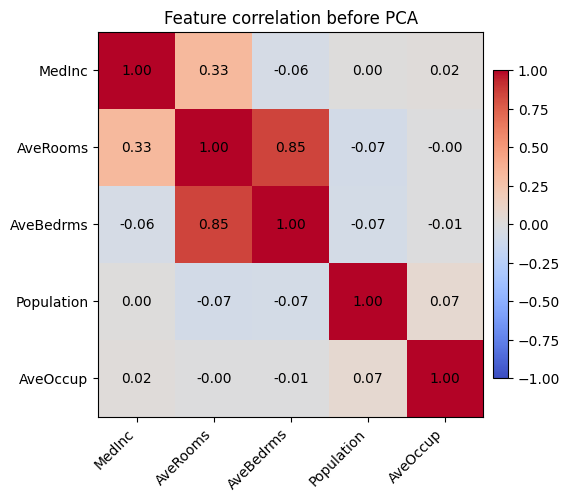

In [21]:
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
selected_features = ['MedInc', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']
feature_indices = [housing.feature_names.index(name) for name in selected_features]
X_housing = housing.data[:, feature_indices]

corr = np.corrcoef(X_housing, rowvar=False)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_xticks(range(len(selected_features)), labels=selected_features, rotation=45, ha='right')
ax.set_yticks(range(len(selected_features)), labels=selected_features)
ax.set_title('Feature correlation before PCA')
for (i, j), value in np.ndenumerate(corr):
    ax.text(j, i, f"{value:.2f}", ha='center', va='center', color='black')
fig.colorbar(im, ax=ax, shrink=0.8, pad=0.02)

plt.show()


The heatmap highlights that average rooms and average bedrooms are almost the same signal, and occupancy-related features move together as well—exactly the kind of multicollinearity that causes coefficient instability.


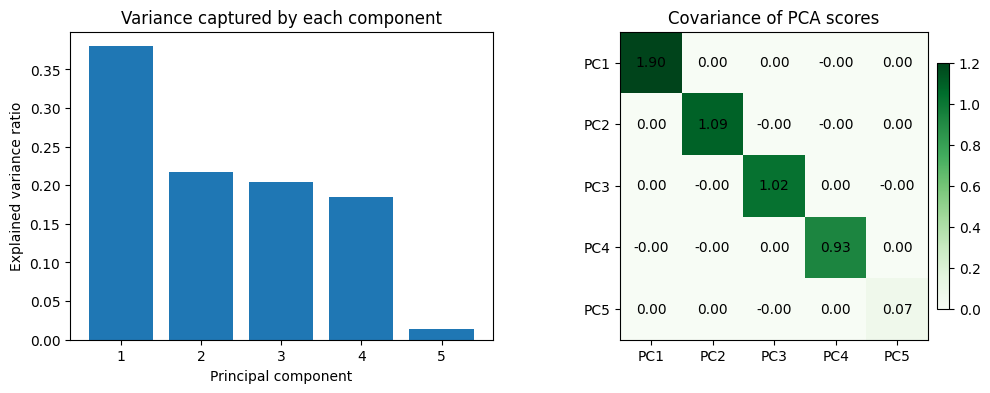

Covariance matrix of PCA-transformed features:
[[ 1.899  0.     0.    -0.     0.   ]
 [ 0.     1.086 -0.    -0.     0.   ]
 [ 0.    -0.     1.02   0.    -0.   ]
 [-0.    -0.     0.     0.926  0.   ]
 [ 0.     0.    -0.     0.     0.069]]


In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_housing)

pca_housing = PCA()
housing_components = pca_housing.fit_transform(X_scaled)
component_cov = np.cov(housing_components, rowvar=False)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].bar(range(1, len(selected_features) + 1), pca_housing.explained_variance_ratio_, color='tab:blue')
axes[0].set_xlabel('Principal component')
axes[0].set_ylabel('Explained variance ratio')
axes[0].set_title('Variance captured by each component')
axes[0].set_xticks(range(1, len(selected_features) + 1))

im = axes[1].imshow(component_cov, cmap='Greens', vmin=0, vmax=1.2)
axes[1].set_title('Covariance of PCA scores')
axes[1].set_xticks(range(len(selected_features)), labels=[f'PC{i}' for i in range(1, len(selected_features) + 1)])
axes[1].set_yticks(range(len(selected_features)), labels=[f'PC{i}' for i in range(1, len(selected_features) + 1)])
for (i, j), value in np.ndenumerate(component_cov):
    axes[1].text(j, i, f"{value:.2f}", ha='center', va='center', color='black')
fig.colorbar(im, ax=axes[1], shrink=0.8, pad=0.02)

plt.show()

print('Covariance matrix of PCA-transformed features:')
print(np.round(component_cov, 3))


After scaling the features, PCA rotates them into orthogonal directions: the covariance matrix of the principal components is almost diagonal.
This decorrelation is what removes multicollinearity—the downstream model now sees independent signals ordered by the variance they explain, and we can keep only the leading components if we want an even smaller, well-conditioned feature set.


## Example: Eigenfaces

Earlier we explored an example of using a PCA projection as a feature selector for facial recognition with a support vector machine (see [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb)).
Here we will take a look back and explore a bit more of what went into that.
Recall that we were using the Labeled Faces in the Wild (LFW) dataset made available through Scikit-Learn:

In [23]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

/opt/anaconda3/envs/rishabh_sat/lib/python3.12/site-packages/sklearn/datasets/_base.py:1472: UserWarning: Retry downloading from url: https://ndownloader.figshare.com/files/5976012
  warnings.warn(f"Retry downloading from url: {remote.url}")


['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Let's take a look at the principal axes that span this dataset.
Because this is a large dataset, we will use the `"random"` eigensolver in the `PCA` estimator: it uses a randomized method to approximate the first $N$ principal components more quickly than the standard approach, at the expense of some accuracy. This trade-off can be useful for high-dimensional data (here, a dimensionality of nearly 3,000).
We will take a look at the first 150 components:

In [ ]:
pca = PCA(150, svd_solver='randomized', random_state=42)
pca.fit(faces.data)

PCA(n_components=150, random_state=42, svd_solver='randomized')

In this case, it can be interesting to visualize the images associated with the first several principal components (these components are technically known as *eigenvectors*,
so these types of images are often called *eigenfaces*; as you can see in the following figure, they are as creepy as they sound):

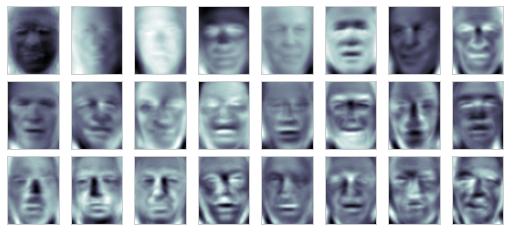

In [ ]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

The results are very interesting, and give us insight into how the images vary: for example, the first few eigenfaces (from the top left) seem to be associated with the angle of lighting on the face, and later principal vectors seem to be picking out certain features, such as eyes, noses, and lips.
Let's take a look at the cumulative variance of these components to see how much of the data information the projection is preserving (see the following figure):

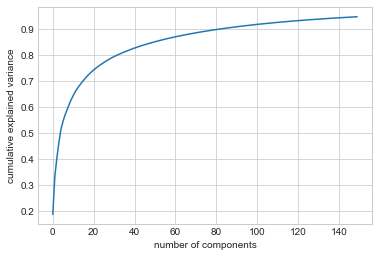

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

The 150 components we have chosen account for just over 90% of the variance.
That would lead us to believe that using these 150 components, we would recover most of the essential characteristics of the data.
To make this more concrete, we can compare the input images with the images reconstructed from these 150 components (see the following figure):

In [ ]:
# Compute the components and projected faces
pca = pca.fit(faces.data)
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

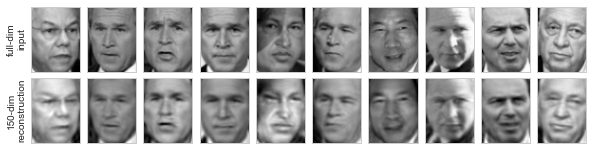

In [ ]:
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')

ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction');

The top row here shows the input images, while the bottom row shows the reconstruction of the images from just 150 of the ~3,000 initial features.
This visualization makes clear why the PCA feature selection used in [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb) was so successful: although it reduces the dimensionality of the data by nearly a factor of 20, the projected images contain enough information that we might, by eye, recognize the individuals in each image. This means our classification algorithm only needs to be trained on 150-dimensional data rather than 3,000-dimensional data, which, depending on the particular algorithm we choose, can lead to much more efficient classification.